somewhere else, do:
```
source $LSSTSW/setup.csh
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -k -r .
setup -t b1898 -r .
setup -t b1898 meas_modelfit
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray' )
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showMasks=True, showVariance=False, showPsf=False, showBars=True, isPsf=False):
    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    ma = image.getMaskedImage().getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars)
    if showVariance and not showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars)
    if showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(image.getPsf().computeImage().getArray(), title='PSF', showBars=showBars)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.meas.modelfit as measMF

100.0
2.0
1800.75


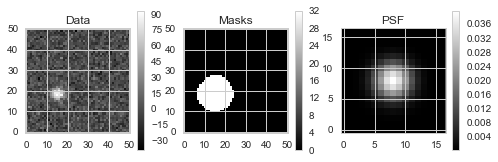

In [3]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=51, h=51, xc=15.3, yc=18.6, flux=2500, psfSigma=2., noise=1.0, schema=None):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    dataset.addSource(flux=flux, centroid=afwGeom.Point2D(xc, yc))
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
    exposure, catalog = dataset.realize(noise=noise, schema=schema)
    return exposure, catalog

exposure, catalog = makeStarImage_lsst(flux=2500, noise=10.)
displayImage(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

The following is taken from `meas_modelfit/tests/testPsfFitter.py`

Note I converted this cell to `RAW` so it won't be evaluated...

The above doesn't seem to centroid.

OK, now this is from `meas_modelfit/examples/fitPsfs.py`... nope, doesn't work. Some code like SdssShapeAlgorithm don't exist anymore.

Let's look at `meas_base/tests/testGaussianCentroid.py` and/or `meas_base/tests/testNaiveCentroid.py` instead...

In [4]:
## functions from lsst.meas.base.tests.AlgorithmTestCase...

from lsst.meas.base.sfm import SingleFrameMeasurementTask
import lsst.daf.base

def makeSingleFrameMeasurementConfig(plugin=None, dependencies=()):
    """Convenience function to create a Config instance for SingleFrameMeasurementTask

    The plugin and its dependencies will be the only plugins run, while the Centroid, Shape,
    and ModelFlux slots will be set to the truth fields generated by the TestDataset class.
    """
    config = SingleFrameMeasurementTask.ConfigClass()
    config.slots.centroid = "truth"
    config.slots.shape = "truth"
    config.slots.modelFlux = None
    config.slots.apFlux = None
    config.slots.psfFlux = None
    config.slots.instFlux = None
    config.slots.calibFlux = None
    config.plugins.names = (plugin,) + tuple(dependencies)
    return config

def makeSingleFrameMeasurementTask(plugin=None, dependencies=(), config=None, schema=None,
                                   algMetadata=None):
    """Convenience function to create a SingleFrameMeasurementTask with a simple configuration.
    """
    if config is None:
        if plugin is None:
            raise ValueError("Either plugin or config argument must not be None")
        config = makeSingleFrameMeasurementConfig(plugin=plugin, dependencies=dependencies)
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
        # Clear all aliases so only those defined by config are set.
        schema.setAliasMap(None)
    if algMetadata is None:
        algMetadata = lsst.daf.base.PropertyList()
    return SingleFrameMeasurementTask(schema=schema, algMetadata=algMetadata, config=config)

In [7]:
## see meas_base/tests/testNaiveCentroid.py
## see meas_base/tests/testGaussianCentroid.py

task = makeSingleFrameMeasurementTask("base_NaiveCentroid")
exposure, catalog = makeStarImage_lsst(xc=15.3, yc=18.6, flux=100000, noise=10., 
                                       schema=task.schema)

task.run(exposure, catalog)
record = catalog[0]
x = record.get("base_NaiveCentroid_x")
y = record.get("base_NaiveCentroid_y")

print x, y
print abs(x-15.3)/15.3, abs(y-18.6)/18.6

15.0476632053 18.0953650416
0.0164926009602 0.0271309117421


In [5]:
def makeImage(xc=15.3, yc=18.6, flux=100000., noise=10., taskName='base_NaiveCentroid'):
    task = makeSingleFrameMeasurementTask(taskName)
    exposure, catalog = makeStarImage_lsst(xc=xc, yc=yc, flux=flux, noise=noise, 
                                       schema=task.schema)
    return task, exposure, catalog

def doit(exposure, catalog, task, taskName='base_NaiveCentroid'):
    task.run(exposure, catalog)
    record = catalog[0]
    x = record.get(taskName + "_x")
    y = record.get(taskName + "_y")
    return x, y

def doall(xc=15.3, yc=18.6, flux=100000., noise=10., taskName='base_NaiveCentroid'):
    task, exposure, catalog = makeImage(xc=xc, yc=yc, flux=flux, noise=noise, taskName=taskName)
    return doit(exposure, catalog, task, taskName=taskName)

In [6]:
task, exposure, catalog = makeImage(flux=10000., taskName='base_NaiveCentroid')
%timeit x, y = doit(exposure, catalog, task, taskName='base_NaiveCentroid')
print x, y

1000 loops, best of 3: 1.5 ms per loop


NameError: name 'x' is not defined

In [ ]:
task, exposure, catalog = makeImage(flux=10000., taskName='base_GaussianCentroid')
%timeit x, y = doit(exposure, catalog, task, taskName='base_GaussianCentroid')
print x, y

In [ ]:
task, exposure, catalog = makeImage(flux=10000., taskName='base_SdssCentroid')
%timeit x, y = doit(exposure, catalog, task, taskName='base_SdssCentroid')
print x, y

Runtimes for running actual SdssCentroid algorithm itself...

In [9]:
## Test the algorithm itself (code from meas_base/tests/testSdssCentroid.py)

taskName = "base_SdssCentroid"

def makeAlgorithm(ctrl=None):
    """Construct an algorithm (finishing a schema in the process), and return both.
    """
    if ctrl is None:
        ctrl = lsst.meas.base.SdssCentroidControl()
    schema = lsst.meas.base.tests.TestDataset.makeMinimalSchema()
    algorithm = lsst.meas.base.SdssCentroidAlgorithm(ctrl, taskName, schema)
    return algorithm, schema

algorithm, schema = makeAlgorithm(lsst.meas.base.SdssCentroidControl())
task, exposure, catalog = makeImage(flux=10000., taskName=taskName)
record = catalog[0]
algorithm.measure(record, exposure)
x = record.get(taskName + "_x")
y = record.get(taskName + "_y")

print x, y
%timeit algorithm.measure(record, exposure)

15.3088897156 18.6276730598
10000 loops, best of 3: 48 µs per loop


Runtimes for running actual GaussianCentroid algorithm itself...

In [11]:
## Test the GaussianCentroid algorithm itself (code from meas_base/tests/testSdssCentroid.py)

taskName = "base_GaussianCentroid"

def makeAlgorithm():
    """Construct an algorithm (finishing a schema in the process), and return both.
    """
    ctrl = lsst.meas.base.GaussianCentroidControl()
    schema = lsst.meas.base.tests.TestDataset.makeMinimalSchema()
    algorithm = lsst.meas.base.GaussianCentroidAlgorithm(ctrl, taskName, schema)
    return algorithm, schema

algorithm, schema = makeAlgorithm()
task, exposure, catalog = makeImage(flux=10000., taskName=taskName)
record = catalog[0]
algorithm.measure(record, exposure)
x = record.get(taskName + "_x")
y = record.get(taskName + "_y")

print x, y
%timeit algorithm.measure(record, exposure)

15.3046684577 18.6244054727
1000 loops, best of 3: 226 µs per loop


I just learned that the best psf measurement code is in meas_extensions.psfex.

Let's take a look at that and benchmark it... look at `meas_extensions_psfex/python/lsst/meas/extensions/psfex/psfexPsfDeterminer.py`...

Actually, let's do it in a different notebook, [9a](9a.%20test%20lsst%20psfex%20fitting%20routines.ipynb).

OK, looks like this is about 50x faster than my python-based dipole fitting routine.
And that means it's about 200x faster than the `ip_diffim` routine.

Well, let's see -- my previous tests ran the `ip_diffim` `task`, not the `algorithm`.
Let's do that in notebook 9a.

Actually, that seems a bit too hard right now, let's look at profiling output (code taken from notebook 8e.):

In [ ]:
%prun result = fitDipole_ipDiffim(exposure=dipole, sCat=s)

The above suggests that it actually spends about 18ms in the `PsfDipoleFlux_measure` code.

Actually about 22ms in `dipoleMeasurement.run`:

```
        1    0.000    0.000    0.022    0.022 dipoleMeasurement.py:329(run)
```
This is about 10x slower than the `GaussianCentroid` algorithm above.
If we can speed this up by a factor of ~5 by cutting the number of function calls from ~200 to ~40, then we are in bizness.
```
ncalls    the number of calls,
tottime   the total time spent in the given function (and excluding time made in calls to sub-functions),
percall   the quotient of tottime divided by ncalls
cumtime   the total time spent in this and all subfunctions (from invocation till exit). This figure is accurate even for recursive functions.
percall   the quotient of cumtime divided by primitive calls
```

```
        24927 function calls (24884 primitive calls) in 0.069 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.018    0.018    0.018    0.018 {_diffimLib.PsfDipoleFlux_measure}
     2098    0.013    0.000    0.013    0.000 {posix.stat}
       60    0.006    0.000    0.033    0.001 traceback.py:281(extract_stack)
     2218    0.004    0.000    0.021    0.000 compilerop.py:137(check_linecache_ipython)
     2218    0.003    0.000    0.017    0.000 linecache.py:47(checkcache)
     2218    0.002    0.000    0.004    0.000 linecache.py:13(getline)
       33    0.002    0.000    0.002    0.000 {_tableLib.Schema__find_Angle}
       33    0.002    0.000    0.002    0.000 {_tableLib.Schema__find_F}
       33    0.002    0.000    0.002    0.000 {_tableLib.Schema__find_L}
       32    0.002    0.000    0.002    0.000 {_tableLib.Schema__find_String}
       32    0.002    0.000    0.002    0.000 {_tableLib.Schema__find_U}
     2218    0.001    0.000    0.001    0.000 {method 'update' of 'dict' objects}
     2218    0.001    0.000    0.001    0.000 linecache.py:33(getlines)
     1918    0.001    0.000    0.001    0.000 {method 'strip' of 'str' objects}
       32    0.001    0.000    0.012    0.000 tableLib.py:1046(find)
     2327    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
2263/2253    0.000    0.000    0.001    0.000 {len}
       34    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_D}
     13/8    0.000    0.000    0.031    0.004 config.py:448(__new__)
      176    0.000    0.000    0.001    0.000 wrappers.py:36(__init__)
      176    0.000    0.000    0.001    0.000 wrappers.py:111(translate)
      387    0.000    0.000    0.000    0.000 {getattr}
        1    0.000    0.000    0.000    0.000 {_baseLib.CircularApertureFluxAlgorithm_measure}
    48/24    0.000    0.000    0.008    0.000 tableLib.py:2356(get)
      199    0.000    0.000    0.000    0.000 {hasattr}
        4    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_I}
       78    0.000    0.000    0.004    0.000 config.py:668(__setattr__)
      120    0.000    0.000    0.000    0.000 linecache.py:72(updatecache)
       20    0.000    0.000    0.017    0.001 config.py:499(update)
        1    0.000    0.000    0.000    0.000 {_diffimLib.new_NaiveDipoleCentroid}
       14    0.000    0.000    0.023    0.002 configChoiceField.py:197(__getitem__)
      405    0.000    0.000    0.000    0.000 {isinstance}
      176    0.000    0.000    0.000    0.000 {_exceptionsLib.Exception_what}
        1    0.000    0.000    0.000    0.000 {_diffimLib.new_PsfDipoleFlux}
        1    0.000    0.000    0.000    0.000 {_baseLib.new_CircularApertureFluxAlgorithm}
       42    0.000    0.000    0.000    0.000 config.py:283(__set__)
        2    0.000    0.000    0.000    0.000 timer.py:34(logPairs)
      180    0.000    0.000    0.000    0.000 {method 'strip' of 'unicode' objects}
       27    0.000    0.000    0.000    0.000 {_tableLib.BaseRecord_getSchema}
        1    0.000    0.000    0.000    0.000 {_loggingLib.Log_info}
        7    0.000    0.000    0.006    0.001 listField.py:31(__init__)
        3    0.000    0.000    0.000    0.000 {_loggingLib.Log_log}
        1    0.000    0.000    0.018    0.018 sfm.py:251(run)
      176    0.000    0.000    0.000    0.000 exceptionsLib.py:817(what)
      121    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
        6    0.000    0.000    0.010    0.002 wrap.py:224(setDefaults)
       35    0.000    0.000    0.000    0.000 listField.py:128(__setattr__)
      240    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.023    0.023 configChoiceField.py:181(_getActive)
       10    0.000    0.000    0.000    0.000 listField.py:68(__setitem__)
        1    0.000    0.000    0.003    0.003 dipoleMeasurement.py:296(classify)
        1    0.000    0.000    0.000    0.000 {_tableLib.new_SourceCatalog}
        6    0.000    0.000    0.010    0.002 wrap.py:201(readControl)
        2    0.000    0.000    0.000    0.000 task.py:79(__init__)
        1    0.000    0.000    0.069    0.069 <ipython-input-8-44fa6331d51e>:26(fitDipole_ipDiffim)
        1    0.000    0.000    0.063    0.063 <ipython-input-8-44fa6331d51e>:2(measureDipole)
        1    0.000    0.000    0.001    0.001 applyApCorr.py:44(__init__)
        2    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_Flag}
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_ArrayU}
        2    0.000    0.000    0.003    0.002 dipoleMeasurement.py:382(getSn)
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_ArrayF}
        7    0.000    0.000    0.000    0.000 tableLib.py:1066(addField)
        2    0.000    0.000    0.000    0.000 timer.py:53(logInfo)
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_ArrayI}
      120    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
       10    0.000    0.000    0.006    0.001 listField.py:104(insert)
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema__find_ArrayD}
       24    0.000    0.000    0.000    0.000 {_tableLib.BaseRecord_get}
        1    0.000    0.000    0.024    0.024 baseMeasurement.py:279(initializePlugins)
       33    0.000    0.000    0.002    0.000 tableLib.py:1155(_find_F)
       22    0.000    0.000    0.000    0.000 baseLib.py:3530(_propertyContainerAdd)
       13    0.000    0.000    0.000    0.000 diffimLib.py:43(_swig_setattr_nondynamic)
        1    0.000    0.000    0.004    0.004 applyApCorr.py:112(__init__)
       38    0.000    0.000    0.000    0.000 config.py:264(__get__)
        6    0.000    0.000    0.000    0.000 wrap.py:187(makeControl)
       60    0.000    0.000    0.000    0.000 {sys.exc_info}
        2    0.000    0.000    0.000    0.000 tableLib.py:3960(__init__)
       68    0.000    0.000    0.000    0.000 {method 'setdefault' of 'dict' objects}
        5    0.000    0.000    0.001    0.000 wrappers.py:222(factory)
       32    0.000    0.000    0.002    0.000 tableLib.py:1199(_find_String)
       22    0.000    0.000    0.000    0.000 baseLib.py:3591(_PL_addValue)
       42    0.000    0.000    0.000    0.000 config.py:51(_autocast)
       18    0.000    0.000    0.000    0.000 baseLib.py:43(_swig_setattr_nondynamic)
        1    0.000    0.000    0.023    0.023 registry.py:148(apply)
        1    0.000    0.000    0.000    0.000 {_diffimLib.new_NaiveDipoleFlux}
       32    0.000    0.000    0.000    0.000 config.py:211(_validateValue)
       14    0.000    0.000    0.000    0.000 {_baseLib.PropertyList_addLongLong}
       28    0.000    0.000    0.000    0.000 {_tableLib.SchemaItem_D_getKey}
       33    0.000    0.000    0.002    0.000 tableLib.py:1243(_find_Angle)
       11    0.000    0.000    0.006    0.001 listField.py:212(__set__)
       32    0.000    0.000    0.002    0.000 tableLib.py:1089(_find_U)
        7    0.000    0.000    0.000    0.000 registry.py:124(__getitem__)
        8    0.000    0.000    0.000    0.000 tableLib.py:9170(__getitem__)
       34    0.000    0.000    0.000    0.000 tableLib.py:1177(_find_D)
        1    0.000    0.000    0.069    0.069 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {_baseLib.new_PixelFlagsAlgorithm}
    17/15    0.000    0.000    0.000    0.000 tableLib.py:9286(__getattribute__)
        4    0.000    0.000    0.000    0.000 {_tableLib.Schema__addField_D}
      5/3    0.000    0.000    0.001    0.000 tableLib.py:2370(set)
        2    0.000    0.000    0.001    0.001 configChoiceField.py:38(__init__)
        1    0.000    0.000    0.028    0.028 sfm.py:233(__init__)
        2    0.000    0.000    0.000    0.000 {_loggingLib.new_Log}
        2    0.000    0.000    0.000    0.000 _methods.py:53(_mean)
        2    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       85    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        3    0.000    0.000    0.003    0.001 configField.py:68(__set__)
        1    0.000    0.000    0.000    0.000 {_baseLib.PsfFluxAlgorithm_measure}
        1    0.000    0.000    0.000    0.000 {_tableLib.SourceTable_defineCentroid}
       12    0.000    0.000    0.000    0.000 abc.py:128(__instancecheck__)
        6    0.000    0.000    0.001    0.000 wrappers.py:13(__init__)
      154    0.000    0.000    0.000    0.000 exceptionsLib.py:1227(<lambda>)
        6    0.000    0.000    0.000    0.000 {_baseLib.PropertyList_addDouble}
        2    0.000    0.000    0.000    0.000 {_baseLib.PropertyList_addString}
       11    0.000    0.000    0.000    0.000 configField.py:58(__get__)
        4    0.000    0.000    0.000    0.000 tableLib.py:3562(__init__)
       10    0.000    0.000    0.000    0.000 registry.py:167(__setattr__)
        9    0.000    0.000    0.000    0.000 diffimLib.py:59(_swig_getattr)
        1    0.000    0.000    0.022    0.022 dipoleMeasurement.py:329(run)
       18    0.000    0.000    0.000    0.000 configChoiceField.py:114(__contains__)
       33    0.000    0.000    0.002    0.000 tableLib.py:1133(_find_L)
        3    0.000    0.000    0.000    0.000 baseLib.py:2781(__init__)
        1    0.000    0.000    0.018    0.018 baseMeasurement.py:305(callMeasure)
       11    0.000    0.000    0.000    0.000 config.py:35(_joinNamePath)
        8    0.000    0.000    0.000    0.000 collections.py:59(__setitem__)
        2    0.000    0.000    0.000    0.000 lsstDebug.py:50(__init__)
        1    0.000    0.000    0.000    0.000 {_baseLib.PixelFlagsAlgorithm_measure}
        3    0.000    0.000    0.000    0.000 {_tableLib.SourceCatalog_subset}
       28    0.000    0.000    0.000    0.000 tableLib.py:3714(getKey)
        1    0.000    0.000    0.001    0.001 dipoleMeasurement.py:414(getOrientation)
        6    0.000    0.000    0.000    0.000 baseLib.py:3169(addDouble)
        9    0.000    0.000    0.000    0.000 configChoiceField.py:244(__setattr__)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2358(__init__)
        1    0.000    0.000    0.004    0.004 dipoleMeasurement.py:55(setDefaults)
        1    0.000    0.000    0.000    0.000 baseLib.py:1942(__init__)
        2    0.000    0.000    0.000    0.000 pluginRegistry.py:162(iterN)
        1    0.000    0.000    0.003    0.003 timer.py:114(wrapper)
        1    0.000    0.000    0.001    0.001 dipoleMeasurement.py:398(getCentroid)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2454(__init__)
       12    0.000    0.000    0.000    0.000 baseLib.py:59(_swig_getattr)
       13    0.000    0.000    0.000    0.000 config.py:490(setDefaults)
        7    0.000    0.000    0.000    0.000 pluginRegistry.py:87(__call__)
        9    0.000    0.000    0.000    0.000 tableLib.py:43(_swig_setattr_nondynamic)
        6    0.000    0.000    0.018    0.003 wrappers.py:17(measure)
       24    0.000    0.000    0.000    0.000 collections.py:121(itervalues)
        1    0.000    0.000    0.028    0.028 dipoleMeasurement.py:279(__init__)
        2    0.000    0.000    0.000    0.000 loggingLib.py:929(__init__)
       60    0.000    0.000    0.000    0.000 {method 'reverse' of 'list' objects}
       45    0.000    0.000    0.000    0.000 {method 'itervalues' of 'dict' objects}
       15    0.000    0.000    0.000    0.000 _weakrefset.py:70(__contains__)
        7    0.000    0.000    0.000    0.000 tableLib.py:59(_swig_getattr)
       27    0.000    0.000    0.000    0.000 tableLib.py:2214(getSchema)
        1    0.000    0.000    0.000    0.000 {_baseLib.new_PsfFluxAlgorithm}
       18    0.000    0.000    0.000    0.000 registry.py:127(__contains__)
        1    0.000    0.000    0.000    0.000 {_baseLib.ApertureFluxControl_radii_set}
        8    0.000    0.000    0.000    0.000 pluginRegistry.py:153(iter)
        1    0.000    0.000    0.000    0.000 baseMeasurement.py:169(setupSchema)
        2    0.000    0.000    0.001    0.001 configChoiceField.py:120(_setSelection)
        2    0.000    0.000    0.000    0.000 baseLib.py:3205(__init__)
        2    0.000    0.000    0.000    0.000 {_tableLib.Schema__addField_Flag}
        1    0.000    0.000    0.003    0.003 configurableField.py:202(__set__)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2375(__init__)
        7    0.000    0.000    0.000    0.000 baseMeasurement.py:96(__init__)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2785(mean)
        1    0.000    0.000    0.000    0.000 {_tableLib.SourceTable_makeMinimalSchema}
        1    0.000    0.000    0.000    0.000 baseMeasurement.py:258(__init__)
        2    0.000    0.000    0.000    0.000 baseLib.py:2088(__init__)
        2    0.000    0.000    0.002    0.001 tableLib.py:1039(__contains__)
       18    0.000    0.000    0.000    0.000 registry.py:113(__contains__)
        2    0.000    0.000    0.000    0.000 {built-in method utcnow}
       24    0.000    0.000    0.000    0.000 listField.py:66(__len__)
        2    0.000    0.000    0.000    0.000 baseMeasurement.py:343(callMeasureN)
       10    0.000    0.000    0.000    0.000 listField.py:47(validateItem)
        2    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        1    0.000    0.000    0.000    0.000 baseLib.py:2119(__init__)
        2    0.000    0.000    0.000    0.000 baseLib.py:1656(__init__)
       11    0.000    0.000    0.000    0.000 {setattr}
        1    0.000    0.000    0.000    0.000 diffimLib.py:2593(__init__)
        1    0.000    0.000    0.001    0.001 configurableField.py:42(__init__)
       24    0.000    0.000    0.000    0.000 collections.py:78(__iter__)
        7    0.000    0.000    0.000    0.000 tableLib.py:9261(__iter__)
        3    0.000    0.000    0.000    0.000 {_baseLib.new_PropertyList}
        2    0.000    0.000    0.002    0.001 configChoiceField.py:323(__set__)
        1    0.000    0.000    0.000    0.000 configChoiceField.py:103(__init__)
        3    0.000    0.000    0.001    0.000 configChoiceField.py:305(_getOrMake)
       14    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x100186920}
        2    0.000    0.000    0.000    0.000 tableLib.py:9499(getChildren)
        1    0.000    0.000    0.001    0.001 configurableField.py:28(__initValue)
        1    0.000    0.000    0.000    0.000 geomLib.py:2962(__init__)
        1    0.000    0.000    0.000    0.000 baseMeasurement.py:388(_applyApCorrIfWanted)
        1    0.000    0.000    0.000    0.000 {_diffimLib.NaiveDipoleFlux_measure}
        1    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase_addNew}
        2    0.000    0.000    0.000    0.000 loggingLib.py:1497(<lambda>)
        7    0.000    0.000    0.000    0.000 pluginRegistry.py:84(ConfigClass)
        2    0.000    0.000    0.000    0.000 {time.clock}
        1    0.000    0.000    0.000    0.000 collections.py:38(__init__)
        1    0.000    0.000    0.000    0.000 {_tableLib.SourceRecord_updateCoord}
        1    0.000    0.000    0.000    0.000 {_diffimLib.NaiveDipoleCentroid_measure}
        2    0.000    0.000    0.001    0.001 configurableField.py:187(__getOrMake)
       14    0.000    0.000    0.000    0.000 baseLib.py:3077(addLongLong)
        1    0.000    0.000    0.000    0.000 tableLib.py:9403(__init__)
        1    0.000    0.000    0.004    0.004 configurableField.py:72(apply)
        3    0.000    0.000    0.000    0.000 {_tableLib.BaseRecord_set}
        1    0.000    0.000    0.004    0.004 task.py:211(makeSubtask)
        7    0.000    0.000    0.000    0.000 sfm.py:59(__init__)
        4    0.000    0.000    0.000    0.000 geomLib.py:2908(__getitem__)
        1    0.000    0.000    0.000    0.000 {sorted}
        2    0.000    0.000    0.000    0.000 {_tableLib._Catalog_equal_range}
       14    0.000    0.000    0.000    0.000 registry.py:110(__getitem__)
        1    0.000    0.000    0.000    0.000 plugins.py:309(measure)
       10    0.000    0.000    0.000    0.000 tableLib.py:9166(__len__)
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema_getNames}
        2    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2559(__init__)
       28    0.000    0.000    0.000    0.000 tableLib.py:3694(<lambda>)
        1    0.000    0.000    0.000    0.000 baseLib.py:3240(__init__)
        2    0.000    0.000    0.000    0.000 detectionLib.py:1128(__getitem__)
        1    0.000    0.000    0.000    0.000 wrappers.py:219(factory)
        3    0.000    0.000    0.000    0.000 {_tableLib.SourceRecord_getFootprint}
        2    0.000    0.000    0.000    0.000 {_loggingLib._getDefaultAsScreenLog}
        6    0.000    0.000    0.000    0.000 diffimLib.py:2389(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:3365(__init__)
        3    0.000    0.000    0.000    0.000 tableLib.py:8537(getFootprint)
        4    0.000    0.000    0.000    0.000 tableLib.py:1111(_find_I)
        2    0.000    0.000    0.000    0.000 {_baseLib.new_ApertureFluxControl}
        4    0.000    0.000    0.000    0.000 tableLib.py:3550(<lambda>)
        4    0.000    0.000    0.000    0.000 {_tableLib.SimpleRecord_getId}
        1    0.000    0.000    0.000    0.000 registry.py:130(__init__)
       10    0.000    0.000    0.000    0.000 {method 'indices' of 'slice' objects}
        1    0.000    0.000    0.000    0.000 {_imageLib.ExposureF_getInfo}
       32    0.000    0.000    0.000    0.000 {method 'iteritems' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 geomLib.py:3545(__init__)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2639(__init__)
        2    0.000    0.000    0.000    0.000 {method 'isoformat' of 'datetime.datetime' objects}
        4    0.000    0.000    0.000    0.000 tableLib.py:1184(_addField_D)
        2    0.000    0.000    0.000    0.000 choiceField.py:54(_validateValue)
        5    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase___getitem__}
        4    0.000    0.000    0.000    0.000 tableLib.py:3548(<lambda>)
        2    0.000    0.000    0.000    0.000 loggingLib.py:1618(_DefaultLogIsScreenLog)
        5    0.000    0.000    0.000    0.000 baseLib.py:1652(<lambda>)
        3    0.000    0.000    0.000    0.000 {_tableLib.AliasMap_set}
        3    0.000    0.000    0.000    0.000 baseLib.py:2779(<lambda>)
        4    0.000    0.000    0.000    0.000 {_geomLib.Point2D__getitem_nochecking}
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema__addField_F}
        2    0.000    0.000    0.000    0.000 geomLib.py:43(_swig_setattr_nondynamic)
       10    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase___len__}
        2    0.000    0.000    0.000    0.000 {resource.getrusage}
        2    0.000    0.000    0.000    0.000 numeric.py:476(asanyarray)
        2    0.000    0.000    0.000    0.000 geomLib.py:59(_swig_getattr)
        3    0.000    0.000    0.000    0.000 tableLib.py:9452(subset)
        3    0.000    0.000    0.000    0.000 loggingLib.py:1002(log)
        1    0.000    0.000    0.000    0.000 {_detectionLib.Footprint_getPeaks}
        1    0.000    0.000    0.018    0.018 diffimLib.py:2651(measure)
        2    0.000    0.000    0.000    0.000 loggingLib.py:43(_swig_setattr_nondynamic)
        2    0.000    0.000    0.000    0.000 {_diffimLib.new_DipoleCentroidControl}
        2    0.000    0.000    0.000    0.000 tableLib.py:9434(isSorted)
        4    0.000    0.000    0.000    0.000 tableLib.py:7737(getId)
        7    0.000    0.000    0.000    0.000 listField.py:62(<lambda>)
       29    0.000    0.000    0.000    0.000 tableLib.py:3733(<lambda>)
        2    0.000    0.000    0.000    0.000 tableLib.py:9349(equal_range)
        1    0.000    0.000    0.000    0.000 detectionLib.py:2014(getPeaks)
        2    0.000    0.000    0.000    0.000 {_detectionLib.PeakRecord_getF}
        1    0.000    0.000    0.004    0.004 dipoleMeasurement.py:376(__call__)
        2    0.000    0.000    0.000    0.000 {_loggingLib._DefaultLogIsScreenLog}
        1    0.000    0.000    0.000    0.000 _abcoll.py:548(update)
        2    0.000    0.000    0.000    0.000 baseLib.py:1654(<lambda>)
       28    0.000    0.000    0.000    0.000 tableLib.py:1371(<lambda>)
       22    0.000    0.000    0.000    0.000 exceptionsLib.py:1137(<lambda>)
        2    0.000    0.000    0.000    0.000 loggingLib.py:1623(getDefaultLog)
        2    0.000    0.000    0.000    0.000 loggingLib.py:59(_swig_getattr)
        1    0.000    0.000    0.000    0.000 imageLib.py:10631(getInfo)
        1    0.000    0.000    0.000    0.000 baseLib.py:1947(measure)
        2    0.000    0.000    0.000    0.000 {_detectionLib.PeakCatalog___getitem__}
        1    0.000    0.000    0.000    0.000 {_geomLib.new_Angle}
        1    0.000    0.000    0.000    0.000 tableLib.py:8708(makeMinimalSchema)
        1    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase_getSchema}
        1    0.000    0.000    0.000    0.000 configurableField.py:196(__get__)
        2    0.000    0.000    0.000    0.000 tableLib.py:3948(<lambda>)
        2    0.000    0.000    0.000    0.000 listField.py:102(__iter__)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2373(<lambda>)
        7    0.000    0.000    0.000    0.000 {globals}
        2    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase_isSorted}
        2    0.000    0.000    0.000    0.000 configChoiceField.py:91(__iter__)
        2    0.000    0.000    0.000    0.000 detectionLib.py:671(getF)
        1    0.000    0.000    0.000    0.000 {_imageLib.ExposureF_getWcs}
        2    0.000    0.000    0.000    0.000 tableLib.py:1221(_find_Flag)
        1    0.000    0.000    0.000    0.000 geomLib.py:2869(getX)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2354(<lambda>)
        2    0.000    0.000    0.000    0.000 baseLib.py:3216(addString)
        2    0.000    0.000    0.000    0.000 {_diffimLib.new_PsfDipoleFluxControl}
        1    0.000    0.000    0.000    0.000 {_geomLib.new_Point2D}
        1    0.000    0.000    0.000    0.000 {_baseLib.PixelFlagsControl_masksFpCenter_set}
        2    0.000    0.000    0.000    0.000 {_tableLib._SourceCatalogBase_getTable}
        1    0.000    0.000    0.000    0.000 tableLib.py:8885(defineCentroid)
        2    0.000    0.000    0.000    0.000 config.py:702(__eq__)
        1    0.000    0.000    0.000    0.000 tableLib.py:1287(_find_ArrayI)
        4    0.000    0.000    0.000    0.000 tableLib.py:8720(getParentKey)
        2    0.000    0.000    0.000    0.000 tableLib.py:11732(_Catalog_equal_range)
        1    0.000    0.000    0.000    0.000 apCorrRegistry.py:42(getApCorrNameSet)
        3    0.000    0.000    0.000    0.000 baseLib.py:2776(<lambda>)
        3    0.000    0.000    0.000    0.000 tableLib.py:836(set)
        1    0.000    0.000    0.000    0.000 configChoiceField.py:317(__get__)
        1    0.000    0.000    0.000    0.000 sfm.py:279(<dictcomp>)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2610(measure)
        1    0.000    0.000    0.000    0.000 loggingLib.py:1018(info)
        4    0.000    0.000    0.000    0.000 {_tableLib.SourceTable_getParentKey}
        1    0.000    0.000    0.000    0.000 tableLib.py:8541(setFootprint)
        3    0.000    0.000    0.000    0.000 configurableField.py:65(<lambda>)
        1    0.000    0.000    0.000    0.000 geomLib.py:3542(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:986(getAliasMap)
        1    0.000    0.000    0.000    0.000 baseLib.py:1937(<lambda>)
        1    0.000    0.000    0.000    0.000 baseLib.py:2124(measure)
        1    0.000    0.000    0.000    0.000 abc.py:148(__subclasscheck__)
        1    0.000    0.000    0.000    0.000 tableLib.py:1309(_find_ArrayF)
        2    0.000    0.000    0.000    0.000 lsstDebug.py:55(__getattr__)
        1    0.000    0.000    0.000    0.000 tableLib.py:9152(addNew)
        1    0.000    0.000    0.000    0.000 tableLib.py:8661(updateCoord)
        2    0.000    0.000    0.000    0.000 tableLib.py:9358(isSorted)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2392(<lambda>)
        1    0.000    0.000    0.000    0.000 {_baseLib.ApertureFluxControl_shiftKernel_set}
        1    0.000    0.000    0.000    0.000 tableLib.py:3517(getKey)
        1    0.000    0.000    0.000    0.000 {_tableLib.SchemaItem_Flag_getKey}
        1    0.000    0.000    0.000    0.000 geomLib.py:2864(<lambda>)
        4    0.000    0.000    0.000    0.000 {_tableLib.new_FieldBase_D}
        2    0.000    0.000    0.000    0.000 tableLib.py:56(_swig_setattr)
        2    0.000    0.000    0.000    0.000 {_baseLib.new_PixelFlagsControl}
        1    0.000    0.000    0.000    0.000 baseLib.py:3245(measure)
        2    0.000    0.000    0.000    0.000 {_baseLib.new_PsfFluxControl}
        1    0.000    0.000    0.000    0.000 {_imageLib.ExposureF_hasWcs}
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema_getAliasMap}
        1    0.000    0.000    0.000    0.000 geomLib.py:2873(getY)
        2    0.000    0.000    0.000    0.000 loggingLib.py:925(<lambda>)
        4    0.000    0.000    0.000    0.000 {iter}
        4    0.000    0.000    0.000    0.000 baseLib.py:3171(<lambda>)
        2    0.000    0.000    0.000    0.000 {range}
        1    0.000    0.000    0.000    0.000 imageLib.py:10627(hasWcs)
        2    0.000    0.000    0.000    0.000 baseLib.py:2071(<lambda>)
        2    0.000    0.000    0.000    0.000 loggingLib.py:927(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:3351(<lambda>)
        2    0.000    0.000    0.000    0.000 tableLib.py:3946(<lambda>)
        1    0.000    0.000    0.000    0.000 imageLib.py:9632(getApCorrMap)
        6    0.000    0.000    0.000    0.000 wrappers.py:134(getExecutionOrder)
       10    0.000    0.000    0.000    0.000 listField.py:90(__getitem__)
        1    0.000    0.000    0.000    0.000 configurableField.py:102(__getattr__)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2587(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:4116(getKey)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2356(<lambda>)
        2    0.000    0.000    0.000    0.000 {_diffimLib.new_DipoleFluxControl}
        1    0.000    0.000    0.000    0.000 geomLib.py:2867(<lambda>)
        2    0.000    0.000    0.000    0.000 loggingLib.py:1614(_getDefaultAsScreenLog)
        1    0.000    0.000    0.000    0.000 tableLib.py:979(contains)
        2    0.000    0.000    0.000    0.000 {method 'join' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {_tableLib.new_FieldBase_Flag}
        1    0.000    0.000    0.000    0.000 task.py:266(_computeFullName)
        3    0.000    0.000    0.000    0.000 baseLib.py:2069(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:1265(_find_ArrayU)
        1    0.000    0.000    0.000    0.000 geomLib.py:3690(<lambda>)
        1    0.000    0.000    0.000    0.000 {_tableLib.new_FieldBase_F}
        1    0.000    0.000    0.000    0.000 tableLib.py:8947(<lambda>)
        1    0.000    0.000    0.000    0.000 imageLib.py:8628(<lambda>)
        1    0.000    0.000    0.000    0.000 geomLib.py:3544(<lambda>)
        1    0.000    0.000    0.000    0.000 plugins.py:305(getExecutionOrder)
        4    0.000    0.000    0.000    0.000 tableLib.py:3300(<lambda>)
        1    0.000    0.000    0.000    0.000 {method 'copy' of 'set' objects}
        2    0.000    0.000    0.000    0.000 tableLib.py:9078(getTable)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2564(measure)
        2    0.000    0.000    0.000    0.000 tableLib.py:1228(_addField_Flag)
        1    0.000    0.000    0.000    0.000 {_tableLib.Schema_contains}
        1    0.000    0.000    0.000    0.000 tableLib.py:1331(_find_ArrayD)
        1    0.000    0.000    0.000    0.000 noiseReplacer.py:454(end)
        1    0.000    0.000    0.000    0.000 baseLib.py:3238(<lambda>)
        1    0.000    0.000    0.000    0.000 baseLib.py:2113(<lambda>)
        2    0.000    0.000    0.000    0.000 detectionLib.py:712(<lambda>)
        2    0.000    0.000    0.000    0.000 {issubclass}
        2    0.000    0.000    0.000    0.000 tableLib.py:9398(<lambda>)
        1    0.000    0.000    0.000    0.000 {_baseLib.ApertureFluxControl_maxSincRadius_set}
        1    0.000    0.000    0.000    0.000 tableLib.py:9082(getSchema)
        2    0.000    0.000    0.000    0.000 baseLib.py:2094(<lambda>)
        1    0.000    0.000    0.000    0.000 {_imageLib.ExposureInfo_getApCorrMap}
        1    0.000    0.000    0.000    0.000 diffimLib.py:2634(<lambda>)
        1    0.000    0.000    0.000    0.000 imageLib.py:10527(getWcs)
        1    0.000    0.000    0.000    0.000 configurableField.py:61(<lambda>)
        2    0.000    0.000    0.000    0.000 lsstDebug.py:59(__setattr__)
        1    0.000    0.000    0.000    0.000 tableLib.py:1162(_addField_F)
        3    0.000    0.000    0.000    0.000 detectionLib.py:1998(<lambda>)
        1    0.000    0.000    0.000    0.000 {_tableLib.SchemaItem_F_getKey}
        2    0.000    0.000    0.000    0.000 diffimLib.py:2371(<lambda>)
        2    0.000    0.000    0.000    0.000 baseLib.py:1707(<lambda>)
        2    0.000    0.000    0.000    0.000 baseLib.py:3173(<lambda>)
        1    0.000    0.000    0.000    0.000 {_baseLib.PsfFluxControl_badMaskPlanes_set}
        1    0.000    0.000    0.000    0.000 baseLib.py:2110(<lambda>)
        1    0.000    0.000    0.000    0.000 {_tableLib.SourceRecord_setFootprint}
        1    0.000    0.000    0.000    0.000 {_tableLib.SourceRecord_getParent}
        1    0.000    0.000    0.000    0.000 {_diffimLib.PsfDipoleFluxControl_stepSizeFlux_set}
        1    0.000    0.000    0.000    0.000 tableLib.py:903(<lambda>)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2637(<lambda>)
        1    0.000    0.000    0.000    0.000 baseLib.py:3235(<lambda>)
        1    0.000    0.000    0.000    0.000 <string>:8(__new__)
        1    0.000    0.000    0.000    0.000 tableLib.py:8549(getParent)
        1    0.000    0.000    0.000    0.000 configurableField.py:70(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:3536(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:941(getNames)
        1    0.000    0.000    0.000    0.000 tableLib.py:3374(<lambda>)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2364(<lambda>)
        2    0.000    0.000    0.000    0.000 tableLib.py:3497(<lambda>)
        1    0.000    0.000    0.000    0.000 {_geomLib.Point2D_getX}
        1    0.000    0.000    0.000    0.000 {_diffimLib.PsfDipoleFluxControl_maxFnCalls_set}
        1    0.000    0.000    0.000    0.000 diffimLib.py:2554(<lambda>)
        4    0.000    0.000    0.000    0.000 tableLib.py:3571(<lambda>)
        4    0.000    0.000    0.000    0.000 tableLib.py:9474(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:3353(<lambda>)
        1    0.000    0.000    0.000    0.000 baseLib.py:1940(<lambda>)
        2    0.000    0.000    0.000    0.000 tableLib.py:3969(<lambda>)
        1    0.000    0.000    0.000    0.000 diffimLib.py:2557(<lambda>)
        3    0.000    0.000    0.000    0.000 geomLib.py:2979(<lambda>)
        1    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 diffimLib.py:2584(<lambda>)
        1    0.000    0.000    0.000    0.000 detectionLib.py:1341(<lambda>)
        1    0.000    0.000    0.000    0.000 {_diffimLib.PsfDipoleFluxControl_stepSizeCoord_set}
        2    0.000    0.000    0.000    0.000 dipoleMeasurement.py:372(__init__)
        2    0.000    0.000    0.000    0.000 baseLib.py:3211(<lambda>)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2381(<lambda>)
        1    0.000    0.000    0.000    0.000 {_geomLib.Point2D_getY}
        1    0.000    0.000    0.000    0.000 imageLib.py:9714(<lambda>)
        1    0.000    0.000    0.000    0.000 {_baseLib.PixelFlagsControl_masksFpAnywhere_set}
        1    0.000    0.000    0.000    0.000 noiseReplacer.py:451(removeSource)
        1    0.000    0.000    0.000    0.000 tableLib.py:4096(<lambda>)
        1    0.000    0.000    0.000    0.000 {_diffimLib.PsfDipoleFluxControl_errorDef_set}
        1    0.000    0.000    0.000    0.000 noiseReplacer.py:448(insertSource)
        2    0.000    0.000    0.000    0.000 diffimLib.py:2460(<lambda>)
        6    0.000    0.000    0.000    0.000 tableLib.py:8678(<lambda>)
        1    0.000    0.000    0.000    0.000 tableLib.py:4135(<lambda>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```